# Visual Recognition Lab

In this lab we will experiment with convolutional neural networks to process images. We will use Keras with Tensorflow. Here are installation instructions for Keras: https://keras.io/#installation, and here are installation instructions for Tensorflow: https://github.com/tensorflow/tensorflow#download-and-setup. Keras is an easy front-end for Tensorflow that allows you to use high-level layers on top of primitive operations implemented in Tensorflow.

We will take a set of training images and sentences from the MS-COCO dataset (400k sentences) and train our network to detect images that contain women vs. men, based on information from the captions.

First, let's import libraries and make sure you have everything properly installed.

In [1]:
import tensorflow as tf
import numpy as np
import random, json, string, pickle
import keras
import keras.layers
import keras.models
import keras.optimizers
import keras.callbacks
from keras.preprocessing import image
import keras.applications.vgg16 as vgg16
import keras.applications.resnet50 as resnet50
import matplotlib.pyplot as plt
from nltk import word_tokenize
%matplotlib inline

Using TensorFlow backend.


## 1. Loading a Pre-trained Convolutional Neural Network (CNN)

We will load here a VGG network proposed by Simonyan & Zisserman "Very Deep Convolutional Networks for Large-Scale Visual Recognition"

In [2]:
model = vgg16.VGG16(weights='imagenet')
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 224, 224, 3)   0                                            
____________________________________________________________________________________________________
block1_conv1 (Convolution2D)     (None, 224, 224, 64)  1792        input_1[0][0]                    
____________________________________________________________________________________________________
block1_conv2 (Convolution2D)     (None, 224, 224, 64)  36928       block1_conv1[0][0]               
____________________________________________________________________________________________________
block1_pool (MaxPooling2D)       (None, 112, 112, 64)  0           block1_conv2[0][0]               
___________________________________________________________________________________________

## 2. Making predictions on a few images using this network.

The last dense layer "predictions" uses a Softmax activation, so the outputs correspond to probabilities for the 1000 classes in the Imagenet ILSVRC task. We will load an image an make some predictions with this network. I took a picture of my toaster to see what the network outputs. It did quite well.

('Input image size:', (1, 224, 224, 3))
('Prediction scores: ', (1, 1000))

Predictions:
0. waffle_iron(0.922)
1. modem(0.035)
2. vacuum(0.016)
3. mouse(0.015)
4. projector(0.004)
5. space_heater(0.002)
6. can_opener(0.001)
7. toilet_seat(0.001)
8. CD_player(0.001)
9. remote_control(0.000)


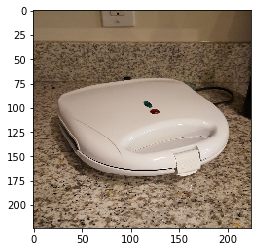

In [3]:
img_path = 'test_image.jpg'  # This is an image I took in my kitchen.
img = image.load_img(img_path, target_size=(224, 224))
img_arr = image.img_to_array(img)
x = np.expand_dims(img_arr, axis=0)  # The model only accepts batches so we add a dummy dimension.
x = vgg16.preprocess_input(x)  # The preprocessing should be the same that was used during training.

predictions = model.predict(x)

label_predictions = vgg16.decode_predictions(predictions, top = 10)

print('Input image size:', x.shape)
print('Prediction scores: ', predictions.shape)
print('\nPredictions:')
for (i, (category_id, name, probability)) in enumerate(label_predictions[0]):
    print('%d. %s(%.3f)' % (i, name, probability))

plt.imshow(np.asarray(img));

## 3. Using a CNN as visual features

We will use the CNN outputs at the "fc2" layer as features in our task of detecting 80 object categories from the MS-COCO dataset. Apart from image descriptions, the MS-COCO dataset contains annotations for 80 object categories with bounding boxes. In this lab we will not be using the bounding boxes so we will only use as a label for each image a vector with 80 dimensions where each entry is a binary value indicating whether an instance of a corresponding object is present.

In [3]:
mscoco_objs = json.load(open('annotations/instances_train2014.json'))

In [4]:
print(mscoco_objs.keys())
print(mscoco_objs['categories'][0])
print(mscoco_objs['annotations'][0])

[u'info', u'images', u'licenses', u'annotations', u'categories']
{u'supercategory': u'person', u'id': 1, u'name': u'person'}
{u'segmentation': [[312.29, 562.89, 402.25, 511.49, 400.96, 425.38, 398.39, 372.69, 388.11, 332.85, 318.71, 325.14, 295.58, 305.86, 269.88, 314.86, 258.31, 337.99, 217.19, 321.29, 182.49, 343.13, 141.37, 348.27, 132.37, 358.55, 159.36, 377.83, 116.95, 421.53, 167.07, 499.92, 232.61, 560.32, 300.72, 571.89]], u'area': 54652.9556, u'iscrowd': 0, u'image_id': 480023, u'bbox': [116.95, 305.86, 285.3, 266.03], u'category_id': 58, u'id': 86}


In [5]:
imageIds = list(set([entry['id'] for entry in mscoco_objs['images']]))[:50000]
imageId2Name = {entry['id']: entry['file_name'] for entry in mscoco_objs['images']}
imageId2index = {image_id: idx for (idx, image_id) in enumerate(imageIds)}
categoryId2index = {entry['id']: idx for (idx, entry) in enumerate(mscoco_objs['categories'])}

labels = np.zeros((len(imageIds), 80))

print('Computing labels'),
simageids = set(imageIds)
for (i, entry) in enumerate(mscoco_objs['annotations']):
    if entry['image_id'] not in simageids: continue
    if i % 10000 == 0: print('.'),
    image_id = entry['image_id']
    category_id = entry['category_id']
    labels[imageId2index[image_id], categoryId2index[category_id]] = 1

print('\n')
print('Labels ', labels.shape)

Computing labels . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 

('Labels ', (50000, 80))


## 4. Compute Visual Features using the CNN.

We will use the CNN outputs at the "fc2" layer as features in our task of detecting 80 object categories. So we need to remove the "predictions" linear layer, let's remove it and verify that the layer is removed by printing the model summary.

In [6]:
# Remove last Linear/Dense layer.
model = vgg16.VGG16(weights='imagenet')
model.layers.pop()
model.outputs = [model.layers[-1].output]
model.layers[-1].outbound_nodes = []
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_2 (InputLayer)             (None, 224, 224, 3)   0                                            
____________________________________________________________________________________________________
block1_conv1 (Convolution2D)     (None, 224, 224, 64)  1792        input_2[0][0]                    
____________________________________________________________________________________________________
block1_conv2 (Convolution2D)     (None, 224, 224, 64)  36928       block1_conv1[0][0]               
____________________________________________________________________________________________________
block1_pool (MaxPooling2D)       (None, 112, 112, 64)  0           block1_conv2[0][0]               
___________________________________________________________________________________________

Let's compute features for all images in the training dataset. You will need to download the training images from the MS-COCO webpage. I'm including the pre-computed vgg16_features.p file so you don't really need to run this code but I encourage you to do it so you have a better idea of computation times for your project.

In [8]:
features = np.zeros((len(imageIds), 4096), dtype=np.float32)

batch_size = 500
n_batches = len(imageIds) / batch_size
index = 0
for b in range(0, n_batches):
    batch = np.zeros((batch_size, 224, 224, 3))
    print(('Computing features for batch %d of %d') % (b + 1, n_batches))
    for i in range(0, batch_size):
        img_path = '/data/data/coco/train2014/' + imageId2Name[imageIds[index]]
        img = image.load_img(img_path, target_size=(224, 224))
        img = image.img_to_array(img)
        batch[i, :, :, :] = img
        index = index + 1
    
    print(('Batch loaded for batch %d of %d') % (b + 1, n_batches))
    batch = vgg16.preprocess_input(batch)
    features[b * batch_size : (b + 1) * batch_size, :] = model.predict(batch)

pickle.dump({'features': features, 'imageIds': imageIds, 'labels': labels,
             'imageId2Name': imageId2Name, 'imageId2index': imageId2index, 'categoryId2index': categoryId2index}, 
            open('vgg16_features.p', 'w'))

Computing features for batch 1 of 100
Batch loaded for batch 1 of 100
Computing features for batch 2 of 100
Batch loaded for batch 2 of 100
Computing features for batch 3 of 100
Batch loaded for batch 3 of 100
Computing features for batch 4 of 100
Batch loaded for batch 4 of 100
Computing features for batch 5 of 100
Batch loaded for batch 5 of 100
Computing features for batch 6 of 100
Batch loaded for batch 6 of 100
Computing features for batch 7 of 100
Batch loaded for batch 7 of 100
Computing features for batch 8 of 100
Batch loaded for batch 8 of 100
Computing features for batch 9 of 100
Batch loaded for batch 9 of 100
Computing features for batch 10 of 100
Batch loaded for batch 10 of 100
Computing features for batch 11 of 100
Batch loaded for batch 11 of 100
Computing features for batch 12 of 100
Batch loaded for batch 12 of 100
Computing features for batch 13 of 100
Batch loaded for batch 13 of 100
Computing features for batch 14 of 100
Batch loaded for batch 14 of 100
Computing 

## 5. Train the model to predict the labels on this task.

Now that we have computed features for each image in our training data. We will try to train the model to predict the labels using a binary cross entropy loss. Remember that this was one of the loss functions you implemented in the Deep Learning Lab. We define here a simple 2-layer neural network that takes input feature vectors and produces 80 probabilities for each object using the output of a sigmoid layer.

In [7]:
# Let's define the model.
# 1. The inputs are feature vectors of size 4096 corresponding to each image.
x = keras.layers.Input(batch_shape = (None, 4096))

# 2. Then we add a linear layer with a ReLU activation and Batch-normalization afterwards.
hidden = keras.layers.Dense(512, activation = 'relu')(x)
hidden = keras.layers.BatchNormalization()(hidden)
hidden = keras.layers.Dropout(0.5)(hidden)

# 3. Add another dense layer with and pass a sigmoid function afterwards.
predictions = keras.layers.Dense(80, activation = 'sigmoid')(hidden)

# 4. Define the inputs and outpus of the model and print a summary.
#    Remember that one could have multiple inputs or outputs.
mlp_model = keras.models.Model(input = [x], output = [predictions])
mlp_model.summary()

# Define the optimization method, and its parameters.
#sgd = keras.optimizers.SGD(lr = 0.01, decay = 1e-2, momentum = 0.9, nesterov = True)
sgd = keras.optimizers.Adam(lr = 0.01, decay = 1e-2)  # Maybe this works better?

# Define the loss function that will be used to compute the error between predictions and labels.
mlp_model.compile(loss='binary_crossentropy', optimizer = sgd, metrics=['accuracy'])

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_3 (InputLayer)             (None, 4096)          0                                            
____________________________________________________________________________________________________
dense_1 (Dense)                  (None, 512)           2097664     input_3[0][0]                    
____________________________________________________________________________________________________
batchnormalization_1 (BatchNorma (None, 512)           2048        dense_1[0][0]                    
____________________________________________________________________________________________________
dropout_1 (Dropout)              (None, 512)           0           batchnormalization_1[0][0]       
___________________________________________________________________________________________

Let's load the precomputed features.

In [8]:
# First load features from file if needed.
precomputed = pickle.load(open('vgg16_features.p'))
features = precomputed['features']
imageIds = precomputed['imageIds']
imageId2Name = precomputed['imageId2Name']
imageId2index = precomputed['imageId2index']
categoryId2index = precomputed['categoryId2index']
labels = precomputed['labels']

Now let's train the model. (Note: again I'm including the mlp_model_weights.hdf5 file in the lab).

In [9]:
train_features = features[:40000, :]
train_labels = labels[:40000, :]
train_imageIds = imageIds[:40000]

val_features = features[40000:, :]
val_labels = labels[40000:, :]
val_imageIds = imageIds[40000:]

mlp_model.fit(train_features, train_labels, 
              validation_data = (val_features, val_labels),
              nb_epoch = 20, batch_size = 128, shuffle = True);

mlp_model.save_weights('mlp_model_weights.hdf5')

Train on 40000 samples, validate on 10000 samples
Epoch 1/20
40000/40000 [==============================] - 3s - loss: 0.1132 - acc: 0.9584 - val_loss: 0.0712 - val_acc: 0.9753



## 6. Try the trained model on some validation data.
Now that we have trained the model we can try running it on some data that we didn't use for training.

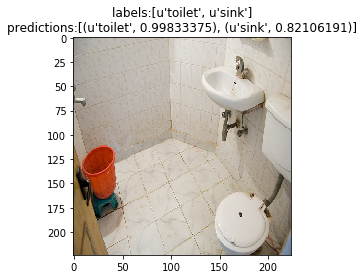

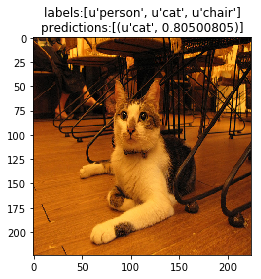

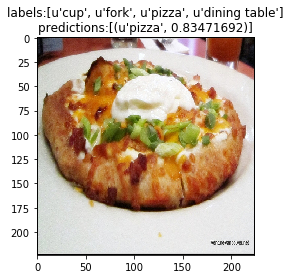

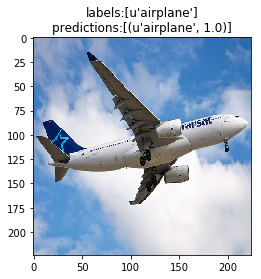

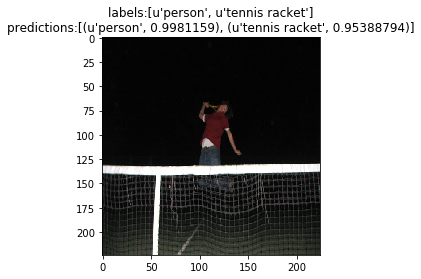

In [10]:
predictions = mlp_model.predict(val_features)

for ind in [2, 3, 4, 39, 14]:
    img_path = '/data/data/coco/train2014/' + imageId2Name[val_imageIds[ind]]
    img = image.load_img(img_path, target_size=(224, 224))
    img_arr = np.expand_dims(image.img_to_array(img), axis = 0)

    plt.figure()
    plt.imshow(np.asarray(img))
  
    vlabels = [mscoco_objs['categories'][idx]['name'] for idx in np.nonzero(val_labels[ind, :])[0]]
    vpreds = [(mscoco_objs['categories'][idx]['name'], predictions[ind, idx]) 
              for idx in np.nonzero(predictions[ind, :] > 0.75)[0]]
    plt.title('labels:' + str(vlabels) + '\npredictions:' + str(vpreds))


## 7. Designing an end-to-end model

In our early model, we extracted features and then trained a model on top of the extracted features. Here we will define a model that integrates the feature extractor (VGG-16), and the model that predicts 80 categories that we defined before.

In [40]:
# Let's define the model.
# 1. The inputs are now RGB images in a batch of size 224x224.
x = keras.layers.Input(batch_shape = (None, 224, 224, 3))

# Load the VGG16 model and remove the last softmax and linear layers.
vgg = vgg16.VGG16(weights='imagenet', include_top = False)
for layer in vgg.layers:  # Maybe let's keep the convolutional layers frozen for faster processing.
    layer.trainable = False
feats = vgg(x)  # "model" is the VGG-16 network without fully connected layers.
feats = keras.layers.Flatten()(feats) # Make the output volume of the convolutional output flat.

# 2. Then we add a linear layer with a ReLU activation and Batch-normalization afterwards.
hidden = keras.layers.Dense(512, activation = 'relu')(feats)
hidden = keras.layers.BatchNormalization()(hidden)
hidden = keras.layers.Dropout(0.5)(hidden)

# 3. Add another dense layer with and pass a sigmoid function afterwards.
predictions = keras.layers.Dense(80, activation = 'sigmoid')(hidden)

# 4. Define the inputs and outpus of the model and print a summary.
#    Remember that one could have multiple inputs or outputs.
full_model = keras.models.Model(input = [x], output = [predictions])
full_model.summary()

# Define the optimization method, and its parameters.
#sgd = keras.optimizers.SGD(lr = 0.01, decay = 1e-2, momentum = 0.9, nesterov = True)
sgd = keras.optimizers.Adam(lr = 0.001, decay = 1e-6)  # Maybe this works better?

# Define the loss function that will be used to compute the error between predictions and labels.
full_model.compile(loss='binary_crossentropy', optimizer = sgd, metrics=['accuracy'])

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_22 (InputLayer)            (None, 224, 224, 3)   0                                            
____________________________________________________________________________________________________
vgg16 (Model)                    multiple              14714688    input_22[0][0]                   
____________________________________________________________________________________________________
flatten_8 (Flatten)              (None, 25088)         0           vgg16[1][0]                      
____________________________________________________________________________________________________
dense_19 (Dense)                 (None, 512)           12845568    flatten_8[0][0]                  
___________________________________________________________________________________________

Now code for training the above model.

In [37]:
import random

# We need to rely on this because we can not load 50k images on memory at the same time.
def DataGenerator(imageIds, imageLabels, batch_size):
    batch = np.zeros((batch_size, 224, 224, 3))
    labels = np.zeros((batch_size, 80))
    while True:
        for i in range(0, batch_size):
            index = random.randint(0, len(imageIds) - 1)
            img_path = '/data/data/coco/train2014/' + imageId2Name[imageIds[index]]
            img = image.load_img(img_path, target_size=(224, 224))
            img = image.img_to_array(img)
            batch[i, :, :, :] = img
            labels[i, :] = imageLabels[index, :]
        batch = vgg16.preprocess_input(batch)
        yield batch, labels

# Why use class weights? 
class_weight = (1 - train_labels).sum(axis = 0) / train_labels.sum(axis = 0)

# The method also does multi-threaded loading for you so you can load batches while the GPU is busy.
samples_per_epoch = len(train_imageIds) / 10
full_model.fit_generator(DataGenerator(train_imageIds, train_labels, 50), samples_per_epoch, nb_epoch = 10,
                         validation_data = DataGenerator(val_imageIds, val_labels, 50),
                         nb_val_samples = len(val_imageIds) / 20,
                         nb_worker = 3, max_q_size = 4, pickle_safe = True,
                         class_weight = class_weight)

full_model.save_weights('full_model_weights.hdf5')

Epoch 1/10
4000/4000 [==============================] - 94s - loss: 0.7438 - acc: 0.6051 - val_loss: 0.4747 - val_acc: 0.8030

## 8. Running the above model on a few inputs.

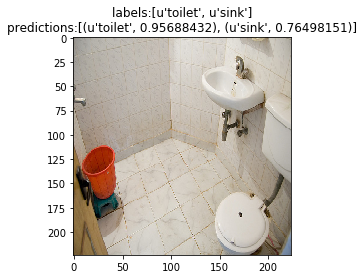

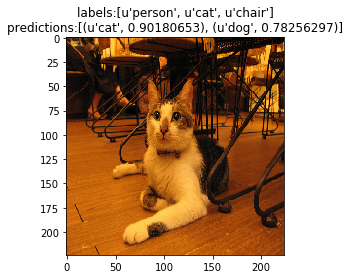

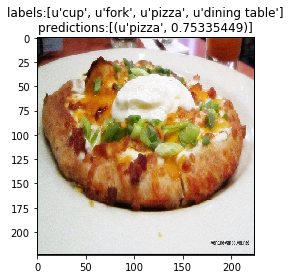

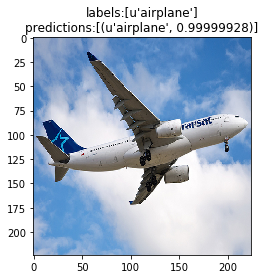

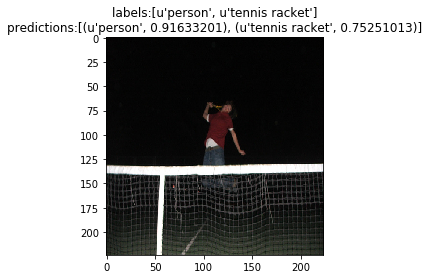

In [38]:
for ind in [2, 3, 4, 39, 14]:
    img_path = '/data/data/coco/train2014/' + imageId2Name[val_imageIds[ind]]
    img = image.load_img(img_path, target_size=(224, 224))
    img_arr = np.expand_dims(image.img_to_array(img), axis = 0)

    plt.figure()
    plt.imshow(np.asarray(img))
    
    img_arr = vgg16.preprocess_input(img_arr)
    predictions = full_model.predict(img_arr)
    #print(predictions)
  
    vlabels = [mscoco_objs['categories'][idx]['name'] for idx in np.nonzero(val_labels[ind, :])[0]]
    vpreds = [(mscoco_objs['categories'][idx]['name'], predictions[0, idx]) 
              for idx in np.nonzero(predictions[0, :] > 0.75)[0]]
    plt.title('labels:' + str(vlabels) + '\npredictions:' + str(vpreds))


## Lab Questions (10pts)
0. Image-Text Captioning/Retrieval: In the Text-Image retrieval lab, we used Color, HOG, and GIST features to retrieve captions from similar images. Compute the performance of using the 4096-dimensional fc2 features of VGG16 (4pts). (Optional: Compute the same for ResNet50 +1pt)<br/>
<table>
<tr><td></td><td><b>random</b></td><td><b>color-feature</b></td><td><b>HoG-feature</b></td><td><b>VGG16-feature</b></td><td><b>Resnet50-feature</b></td></tr>
<tr><td>BLEU-1</td><td>0.00</td><td>0.00</td><td>0.00</td><td>0.00</td><td>0.00</td></tr>
</table><br/>
1. In this lab we took a VGG16 model that was trained to classify an image into 1000 classes using a softmax + categorical_crossentropy loss, and adapted the model to predict 80 categories using a sigmoid + binary_crossentropy loss. Please modify here the VGG16 model (as in Section 7), to predict a category from a set of 20 categories using a softmax + categorical_crossentropy loss, and the location of the object (x1, y1, x2, y2) using a a linear layer + mean squared error regression loss (3pts). This requires multiple outputs and multiple losses from your network, consult Keras documentation for examples of how to do this.[Note that I'm not asking for this model to be trained].

<div style="margin-left:20px"><span>3.</span> Show 3 examples from pictures of your own where the VGG16 model trained on the Imagenet 1000 classes makes correct predictions, and 3 examples where it makes mistakes. Show the same for the VGG16 model adapted to predict 80 classes. (3pts). </div>

### Optional (3pts)

1. Run the code in section 7 and record the computation time that you obtained there, and the final loss on training and validation data. (Note: This will most likely require running things on either a local GPU or an Amazon AWS GPU). Note that the parameters I chose (learning rate, batch size, etc) might not be the optimal for this setting so don't get surprised if this taskes potentially longer. (Honestly don't bother with this item, it will take long, however it will give you perspective about the training times for your class project).

<div style="font-size:0.8em;color:#888;text-align:center;padding-top:20px;">If you find any errors or omissions in this material please contact me at vicente@cs.virginia.edu